In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile, os, cv2
from tqdm.auto import tqdm
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras import layers, callbacks, utils

import imgaug as ia
from imgaug import augmenters as iaa

sns.set_style('darkgrid')

# Data Preparation

In [2]:
path_zip = '../input/denoising-dirty-documents/'
path = '/kaggle/working/'

with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
    
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [3]:
class config():
    IMG_SIZE = (420, 540)

imgs = [cv2.imread(path + 'train/' + f) for f in sorted(os.listdir(path + 'train/'))]
print('Median Dimensions:', np.median([len(img) for img in imgs]), np.median([len(img[0]) for img in imgs]))
del imgs

Median Dimensions: 420.0 540.0


In [4]:
def process_image(path, add_noise=True):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, config.IMG_SIZE[::-1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
    img = img/255.0
    img = np.reshape(img, (*config.IMG_SIZE, 1))
    
    return img

In [5]:
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f, False))
    
for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))
    
train = np.asarray(train)
train_cleaned = np.asarray(train_cleaned)
test = np.asarray(test)

In [6]:
train.shape, train_cleaned.shape, test.shape

((144, 420, 540, 1), (144, 420, 540, 1), (72, 420, 540, 1))

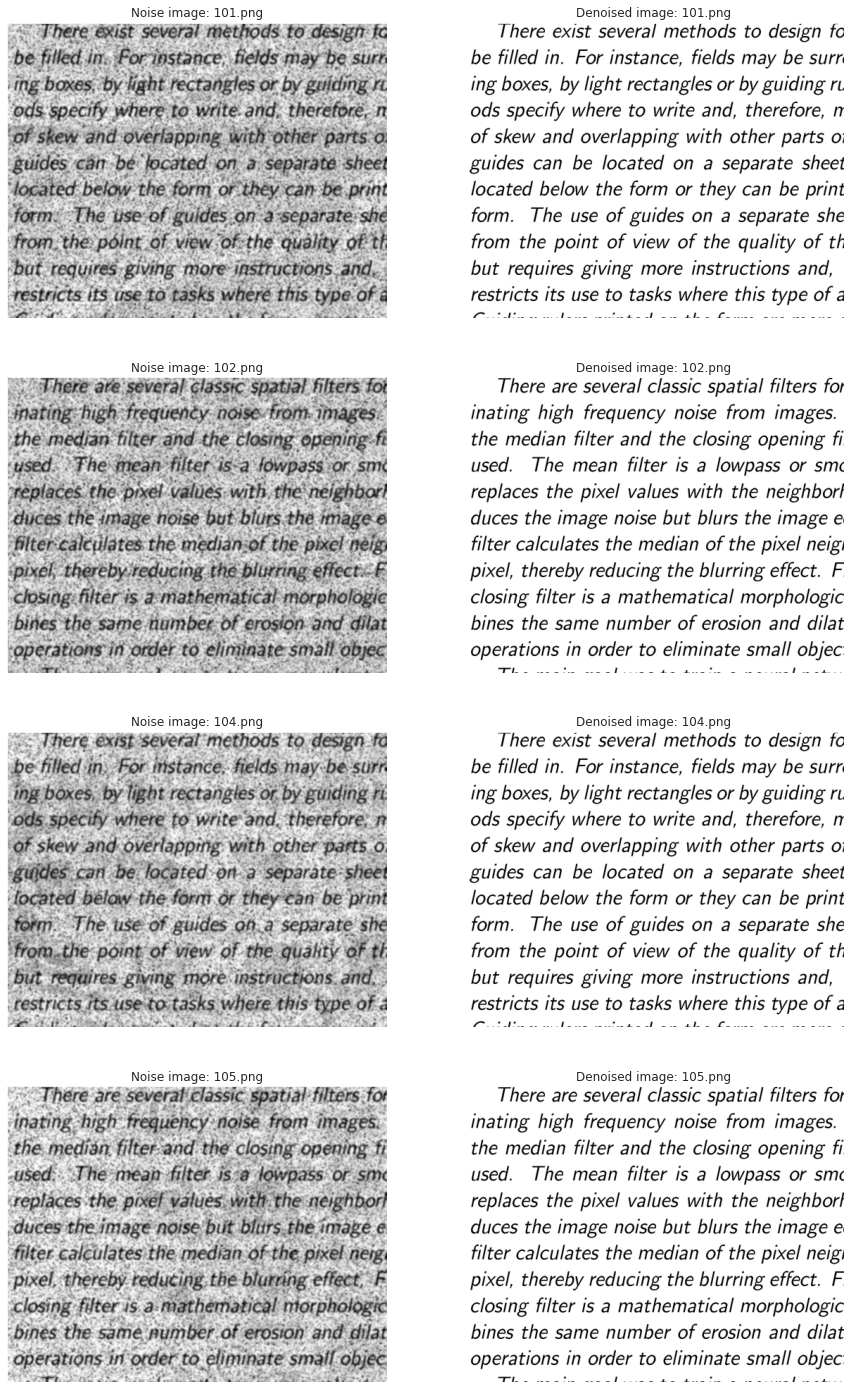

In [7]:
fig, ax = plt.subplots(4, 2, figsize=(15,25))
for i in range(4):
    ax[i][0].imshow(tf.squeeze(train[i]), cmap='gray')
    ax[i][0].set_title('Noise image: {}'.format(train_img[i]))
    
    ax[i][1].imshow(tf.squeeze(train_cleaned[i]), cmap='gray')
    ax[i][1].set_title('Denoised image: {}'.format(train_img[i]))
    
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)

In [8]:
def augment_pipeline(pipeline, images, seed=19):
    ia.seed(seed)
    processed_images = images.copy()
    for step in pipeline:
        temp = np.array(step.augment_images(images))
        processed_images = np.append(processed_images, temp, axis=0)
    return(processed_images)

In [9]:
rotate90 = iaa.Rot90(1)
rotate180 = iaa.Rot90(2)
rotate270 = iaa.Rot90(3)
random_rotate = iaa.Rot90((1,3))
perc_transform = iaa.PerspectiveTransform(scale=(0.02, 0.1))
rotate10 = iaa.Affine(rotate=(10))
rotate10r = iaa.Affine(rotate=(-10))
crop = iaa.Crop(px=(5, 32))
hflip = iaa.Fliplr(1)
vflip = iaa.Flipud(1)
gblur = iaa.GaussianBlur(sigma=(1, 1.5))
motionblur = iaa.MotionBlur(8)

seq_rp = iaa.Sequential([
    iaa.Rot90((1,3)),
    iaa.PerspectiveTransform(scale=(0.02, 0.1))
])

seq_cfg = iaa.Sequential([
    iaa.Crop(px=(5, 32)),
    iaa.Fliplr(0.5),
    iaa.GaussianBlur(sigma=(0, 1.5))
])

seq_fm = iaa.Sequential([
    iaa.Flipud(1),
    iaa.MotionBlur(k=6)
])


In [10]:
pipeline = [
    rotate90, rotate180, rotate270, hflip, vflip
]

In [11]:
processed_train = augment_pipeline(pipeline, train)
processed_train_cleaned = augment_pipeline(pipeline, train_cleaned)

processed_train.shape, processed_train_cleaned.shape

((864, 420, 540, 1), (864, 420, 540, 1))

In [12]:
class DenoisingAutoencoder(Model):
  def __init__(self):
    super(DenoisingAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(*config.IMG_SIZE, 1)), 
        layers.Conv2D(48, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(72, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(144, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Dropout(0.5),
    ])

    self.decoder = tf.keras.Sequential([
        layers.Conv2D(144, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(72, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(48, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = DenoisingAutoencoder()
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [13]:
es = callbacks.EarlyStopping(
    monitor='loss', patience=30, verbose=1, restore_best_weights=True
)

history =  autoencoder.fit(
    processed_train, processed_train_cleaned, 
#
    shuffle=True,
    callbacks=[es], epochs=500, batch_size=12
)

Epoch 1/700
72/72 [==============================] - 44s 617ms/step - loss: 0.0668 - mean_absolute_error: 0.1832
Epoch 2/700
72/72 [==============================] - 44s 616ms/step - loss: 0.0233 - mean_absolute_error: 0.0996
Epoch 3/700
72/72 [==============================] - 44s 617ms/step - loss: 0.0164 - mean_absolute_error: 0.0747
Epoch 4/700
72/72 [==============================] - 44s 617ms/step - loss: 0.0142 - mean_absolute_error: 0.0645
Epoch 5/700
72/72 [==============================] - 44s 617ms/step - loss: 0.0132 - mean_absolute_error: 0.0587
Epoch 6/700
72/72 [==============================] - 44s 617ms/step - loss: 0.0125 - mean_absolute_error: 0.0551
Epoch 7/700
72/72 [==============================] - 45s 619ms/step - loss: 0.0121 - mean_absolute_error: 0.0532
Epoch 8/700
72/72 [==============================] - 44s 617ms/step - loss: 0.0117 - mean_absolute_error: 0.0516
Epoch 9/700
72/72 [==============================] - 44s 617ms/step - loss: 0.0114 - mean_absolu

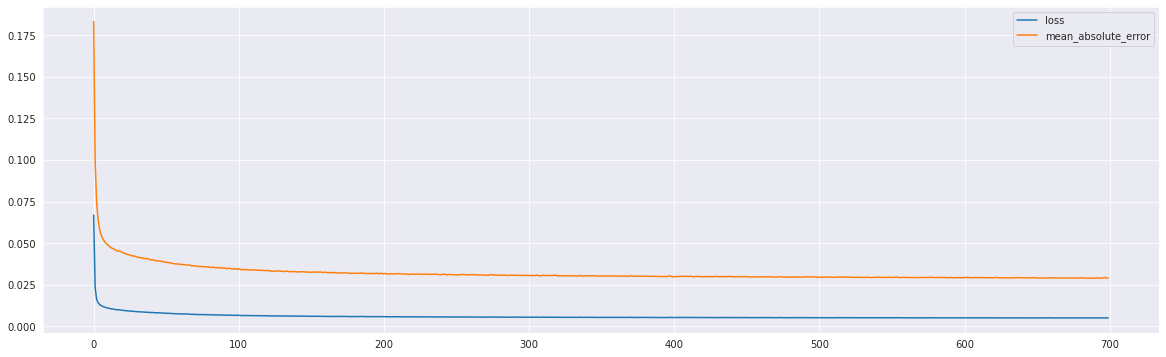

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).plot(ax=ax)
del history

In [15]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 420, 540, 48)      480       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 420, 540, 72)      31176     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 420, 540, 144)     93456     
_________________________________________________________________
batch_normalization (BatchNo (None, 420, 540, 144)     576       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 210, 270, 144)     0         
_________________________________________________________________
dropout (Dropout)            (None, 210, 270, 144)     0         
Total params: 125,688
Trainable params: 125,400
Non-trainable params: 288
________________________________________________

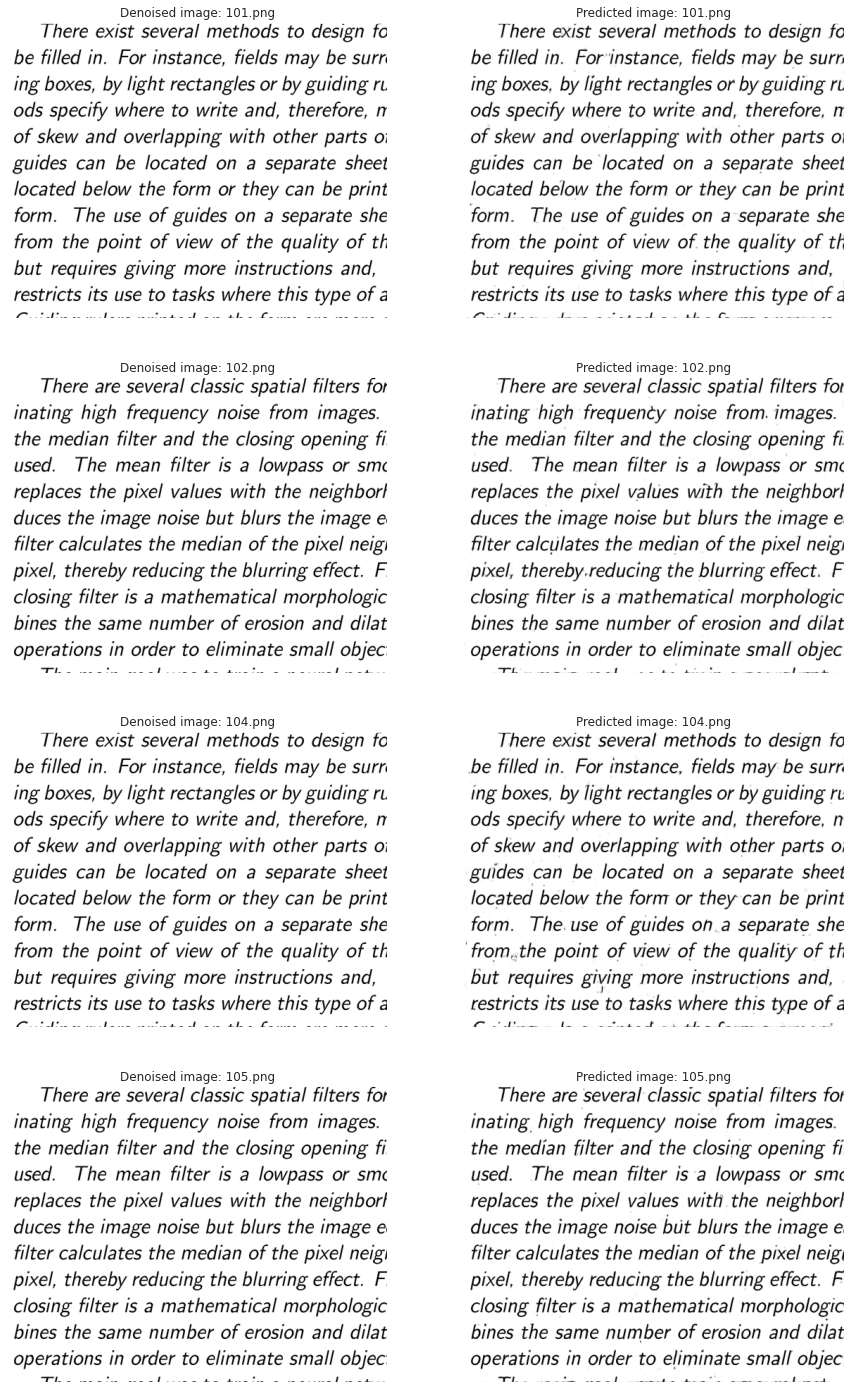

In [16]:
decoded_imgs = autoencoder(train[:4]).numpy()
    
fig, ax = plt.subplots(4, 2, figsize=(15,25))
for i in range(4):
    ax[i][0].imshow(tf.squeeze(train_cleaned[i]), cmap='gray')
    ax[i][0].set_title('Denoised image: {}'.format(train_img[i]))
    
    ax[i][1].imshow(tf.squeeze(decoded_imgs[i]), cmap='gray')
    ax[i][1].set_title('Predicted image: {}'.format(train_img[i]))
    
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)    

del decoded_imgs    

Denoised images saved to: /kaggle/working/denoised_images/


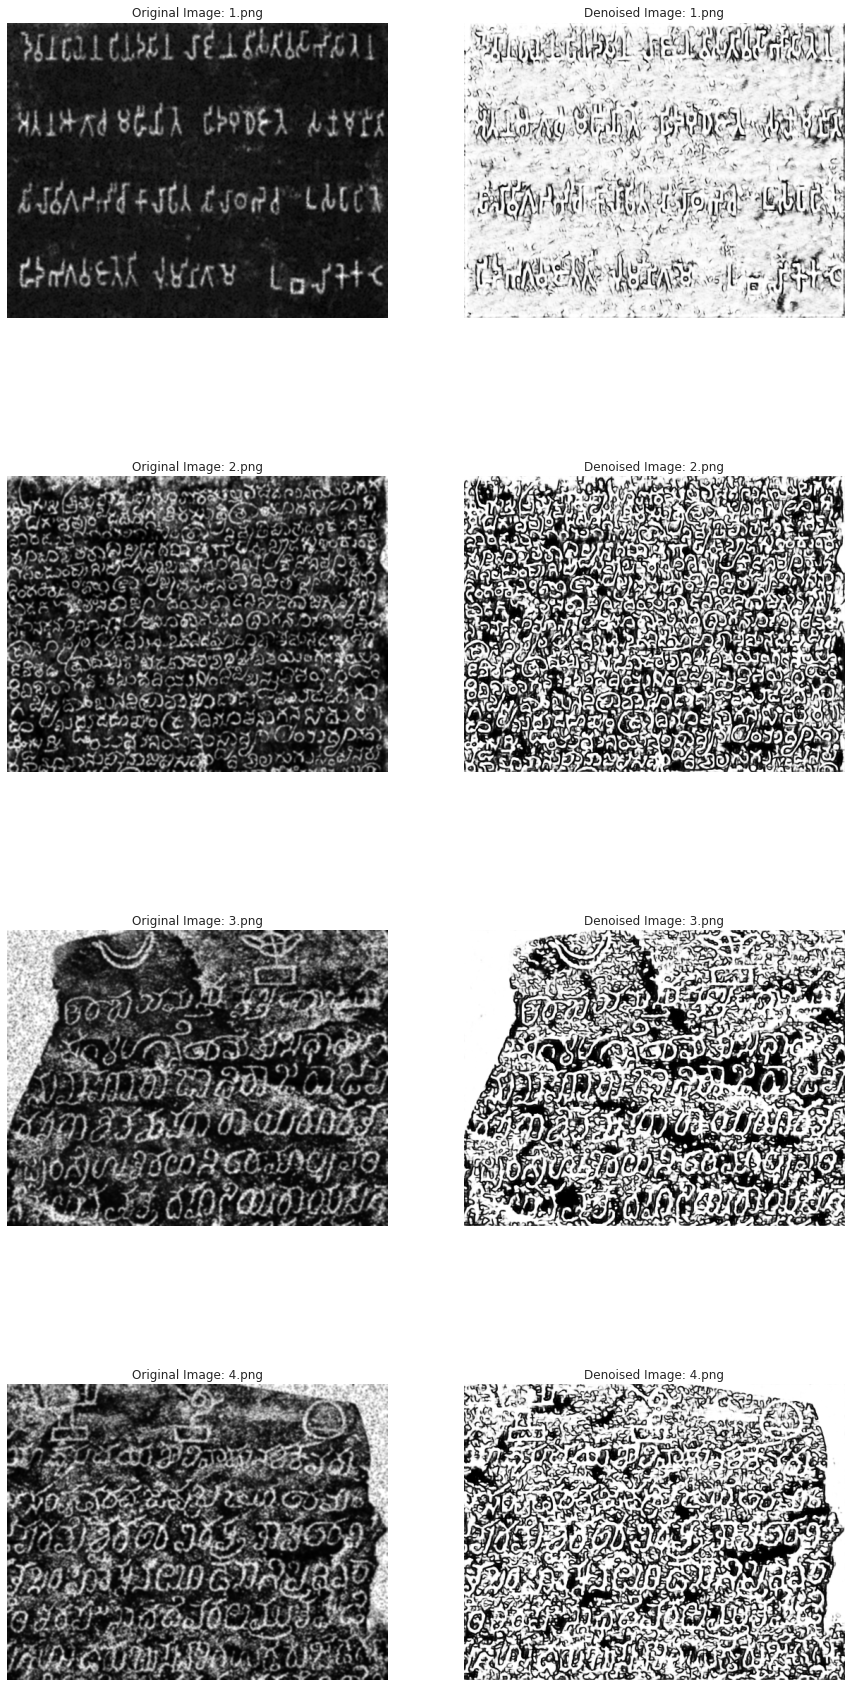

In [17]:
to_be_denoised_path = '/kaggle/input/tobedeniosed/ToBeDenoised/'
to_be_denoised_imgs = sorted(os.listdir(to_be_denoised_path))
to_be_denoised = []
for f in to_be_denoised_imgs:
    img = process_image(to_be_denoised_path + f)
    to_be_denoised.append(img)
to_be_denoised = np.asarray(to_be_denoised)

denoised_imgs = autoencoder.predict(to_be_denoised)

output_path = '/kaggle/working/denoised_images/'
os.makedirs(output_path, exist_ok=True)
for i, img in enumerate(denoised_imgs):
    filename = to_be_denoised_imgs[i]
    cv2.imwrite(output_path + filename, img * 255.0)

    
fig, axes = plt.subplots(len(to_be_denoised), 2, figsize=(15, len(to_be_denoised) * 8))

for i, (img, denoised_img) in enumerate(zip(to_be_denoised, denoised_imgs)):
    axes[i, 0].imshow(tf.squeeze(img), cmap='gray')
    axes[i, 0].set_title('Original Image: {}'.format(to_be_denoised_imgs[i]))
    axes[i, 0].axis('off')

    axes[i, 1].imshow(tf.squeeze(denoised_img), cmap='gray')
    axes[i, 1].set_title('Denoised Image: {}'.format(to_be_denoised_imgs[i]))
    axes[i, 1].axis('off')
    
print("Denoised images saved to:", output_path)